<a href="https://www.kaggle.com/code/bradencruz/gym-crowdedness-prediction?scriptVersionId=252991039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Task for Today

Predict the number of people in a gym at a given time based on data recorded every 10 minutes at a university

Goals:
1. Given a time of day (and maybe some other features, including weather), predict how crowded the gym will be.
2. Figure out which features are actually important, which are redundant, and what features could be added to make the predictions more accurate.

# Getting Started

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowdedness-at-the-campus-gym/data.csv


In [2]:
# taking a look
data = pd.read_csv('/kaggle/input/crowdedness-at-the-campus-gym/data.csv')
data

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17
...,...,...,...,...,...,...,...,...,...,...,...
62179,23,2017-03-18 18:42:28-07:00,67348,5,1,0,61.07,0,1,3,18
62180,21,2017-03-18 18:52:35-07:00,67955,5,1,0,61.07,0,1,3,18
62181,25,2017-03-18 19:02:40-07:00,68560,5,1,0,56.71,0,1,3,19
62182,18,2017-03-18 19:12:47-07:00,69167,5,1,0,56.71,0,1,3,19


In [3]:
# object columns and numeric columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [4]:
# Only use numeric columns for correlation
numeric_data = data.select_dtypes(include='number')
correlation = numeric_data.corr()
print(correlation)

                      number_people  timestamp  day_of_week  is_weekend  \
number_people              1.000000   0.550218    -0.162062   -0.173958   
timestamp                  0.550218   1.000000    -0.001793   -0.000509   
day_of_week               -0.162062  -0.001793     1.000000    0.791338   
is_weekend                -0.173958  -0.000509     0.791338    1.000000   
is_holiday                -0.048249   0.002851    -0.075862   -0.031899   
temperature                0.373327   0.184849     0.011169    0.020673   
is_start_of_semester       0.182683   0.009551    -0.011782   -0.016646   
is_during_semester         0.335350   0.044676    -0.004824   -0.036127   
month                     -0.097854  -0.023221     0.015559    0.008462   
hour                       0.552049   0.999077    -0.001914   -0.000517   

                      is_holiday  temperature  is_start_of_semester  \
number_people          -0.048249     0.373327              0.182683   
timestamp               0.002851

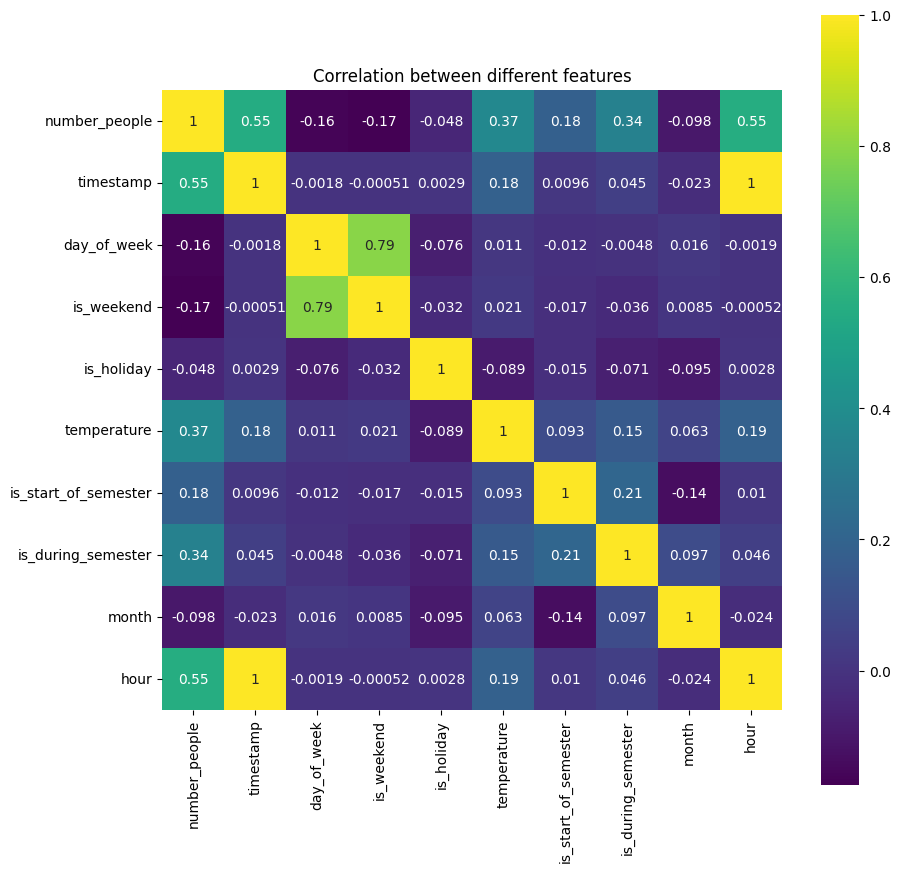

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')

plt.title('Correlation between different features')
plt.show()


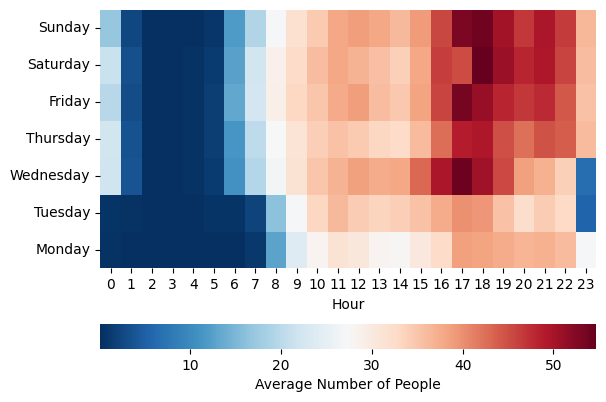

In [6]:
#analyze time in hours instead of seconds


g = data[['hour','number_people','day_of_week']]

#Group by tme and day
F = g.groupby(['hour', 'day_of_week'], as_index=False)['number_people'].mean().pivot(index='day_of_week', columns='hour', values='number_people').fillna(0)



grid_kws = {"height_ratios": (.9, .05), "hspace": .3}

dow= 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()
dow.reverse()

ax = sns.heatmap(F, cmap='RdBu_r',cbar_kws={"orientation": "horizontal"})
ax.set_yticklabels(dow, rotation = 0)
ax.set_ylabel('')
ax.set_xlabel('Hour')

cbar = ax.collections[0].colorbar
cbar.set_label('Average Number of People')

**Best time to go to the gym is early in the morning early in the week**

In [7]:
# Preprocessing

def preprocess_inputs(df):
    df =df.copy()

    # Extracct date features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['hour'] = df['date'].apply(lambda x: x.hour)
    df['minute'] = df['date'].apply(lambda x: x.minute)    
    df = df.drop('date', axis=1 )

    # split df into X and y

    y = df['number_people']
    X = df.drop('number_people', axis=1)

    # Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

# Training

In [9]:
models = {
    'Linear Regression (Ridge)': Ridge(),
    '     Neural Network': MLPRegressor(),
    '     Random Forest': RandomForestRegressor(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained." )

Linear Regression (Ridge) trained.
     Neural Network trained.
     Random Forest trained.


# Results

In [10]:
def get_rmse(y_test, y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    return rmse

def get_r2(y_test, y_pred):
    r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_test.mean())**2))
    return r2

In [11]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Residuals
    residuals = y_test - y_pred

    residuals = pd.Series(residuals, index=y_test.index)

    # Filter positive residuals only (can't take log of negative numbers)
    positive_residuals = residuals[residuals > 0]
    log_residuals = np.log(positive_residuals)
    
    r2 = get_r2(y_test, y_pred)
    rmse = get_rmse(y_test, y_pred)
    print(name + " RMSE: {:.2f}".format(rmse))
    print(name + " R^2: {:.5f}".format(r2))
    print(name + " Mean Log Residuals: {:.5f}".format(log_residuals.mean()))
    rmse = get_rmse(y_test, y_pred)
    results.append({'Model': name, 'R2 Score': r2, 'RMSE': rmse, 'Residuals': residuals})

Linear Regression (Ridge) RMSE: 16.04
Linear Regression (Ridge) R^2: 0.50533
Linear Regression (Ridge) Mean Log Residuals: 2.07304
     Neural Network RMSE: 12.31
     Neural Network R^2: 0.70871
     Neural Network Mean Log Residuals: 1.64046
     Random Forest RMSE: 6.65
     Random Forest R^2: 0.91499
     Random Forest Mean Log Residuals: 0.97065


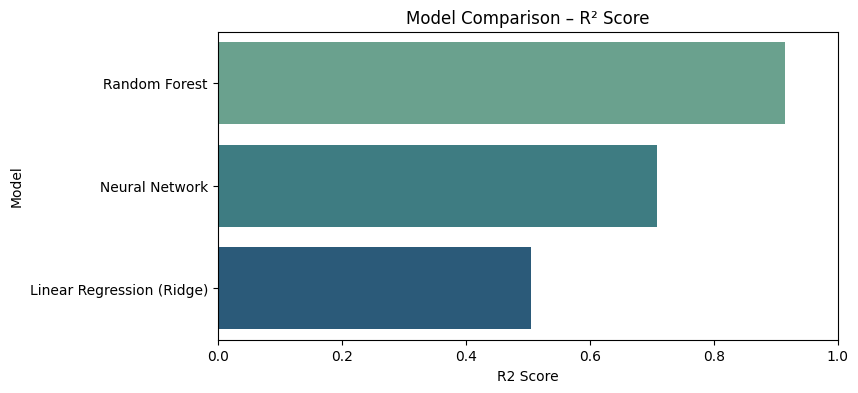

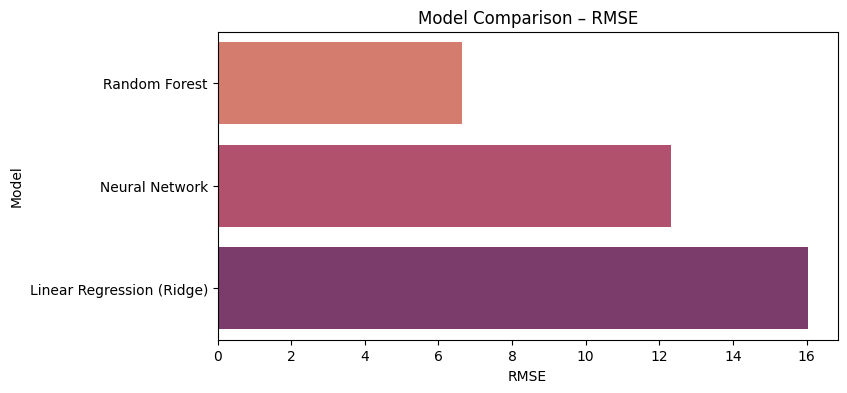

In [12]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by R² or RMSE if you like
results_df = results_df.sort_values(by='R2 Score', ascending=False)

# Plot R² Scores
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x='R2 Score', y='Model', palette='crest')
plt.title('Model Comparison – R² Score')
plt.xlim(0, 1)
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x='RMSE', y='Model', palette='flare')
plt.title('Model Comparison – RMSE')
plt.show()

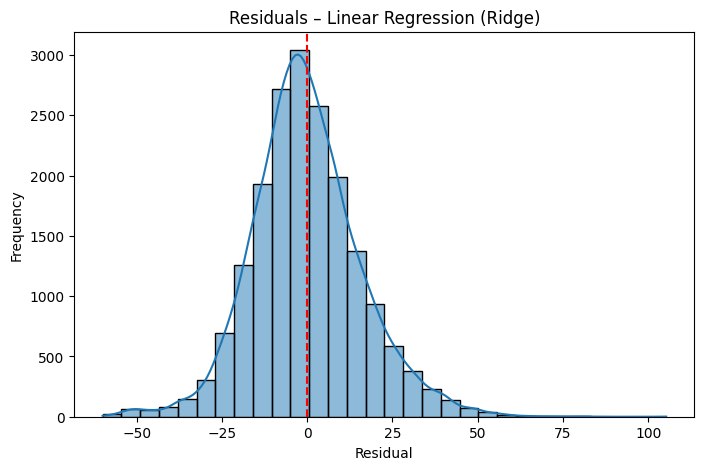

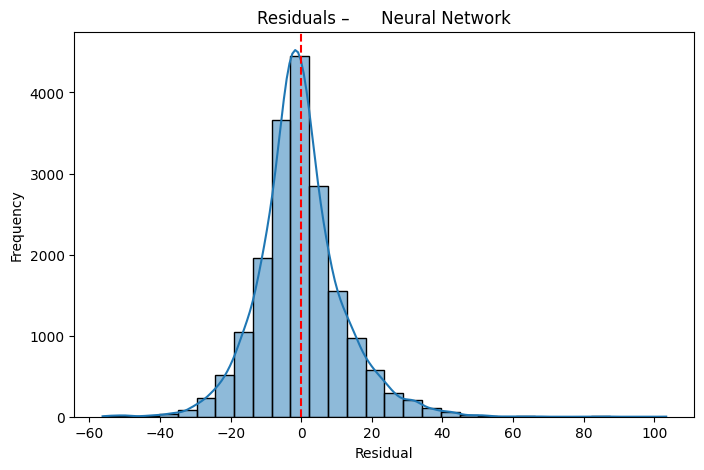

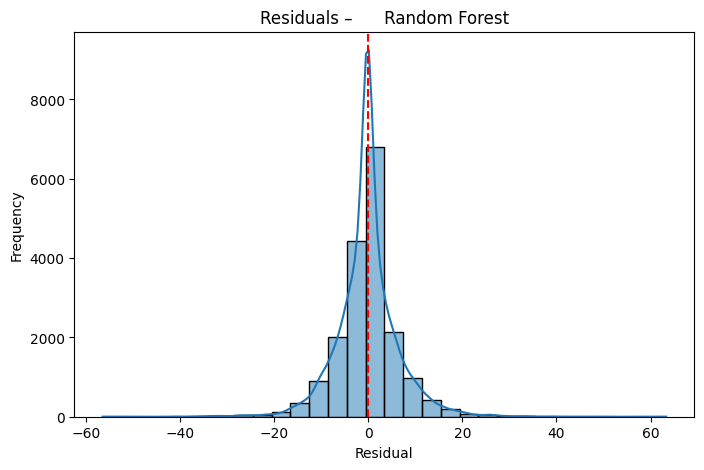

In [13]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # ✅ use X_test
    residuals = y_test - y_pred     # ✅ match y_test

    plt.figure(figsize=(8, 5))      # ✅ create new figure
    sns.histplot(residuals, kde=True, bins=30)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'Residuals – {name}')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()